In [1]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy

from agetdata import get_currents_with_constant_dt

In [2]:
result_dir = "./Results"
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    else:
        print("The folder already exsits")
except OSError:
    print(f"Error: {result_dir} has not been created.")

The folder already exsits


In [3]:
end_time = 1000
bcl = 1000
duration = 0.5
offset = 20

t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 5000)  

extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL_total', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa']

In [12]:
start_time = time.time()

model, p, s = myokit.load("../../../mmt-model-files/ohara-cipa-v1-2017_JK-v1.mmt")    
protocol = myokit.pacing.blocktrain(bcl, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0  
sim = simulator_myokit.Simulator(model, protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=0)  # 1e-12, 1e-14  # 1e-08, 1e-10

model_params = {         
    'cell.mode': 2,
    'setting.simType': 0,   # 0: AP   |  1: VC      
}
sim.set_simulation_params(model_params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.498623847961426 seconds ---


In [13]:
start_time = time.time()

model_params = {         
    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 1,
    'ical.g_adj' : 1,
    'ikr.g_adj' : 1,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1,    
}
sim.set_simulation_params(model_params)  
y0 = sim.pre_simulate(bcl*100, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = d['membrane.V']
sol1["I_total"] = d['membrane.i_ion']
sol1["INa"] = d['ina.INa']
sol1["INaL"] = d['inal.INaL']
sol1["Ito"] = d['ito.Ito']
sol1["ICaL"] = d['ical.ICaL_total']
sol1["IKr"] = d['ikr.IKr']
sol1["IKs"] = d['iks.IKs']
sol1["IK1"] = d['ik1.IK1']

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.1393880844116211 seconds ---


In [14]:
start_time = time.time()

model_params = {         
    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 1,
    'ical.g_adj' : 1,
    'ikr.g_adj' : 0.1,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1,    
}
sim.set_simulation_params(model_params)  
y0 = sim.pre_simulate(bcl*100, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol2 = {}
times2 = d['engine.time']
sol2["Voltage"] = d['membrane.V']
sol2["I_total"] = d['membrane.i_ion']
sol2["INa"] = d['ina.INa']
sol2["INaL"] = d['inal.INaL']
sol2["Ito"] = d['ito.Ito']
sol2["ICaL"] = d['ical.ICaL_total']
sol2["IKr"] = d['ikr.IKr']
sol2["IKs"] = d['iks.IKs']
sol2["IK1"] = d['ik1.IK1']

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.2750072479248047 seconds ---


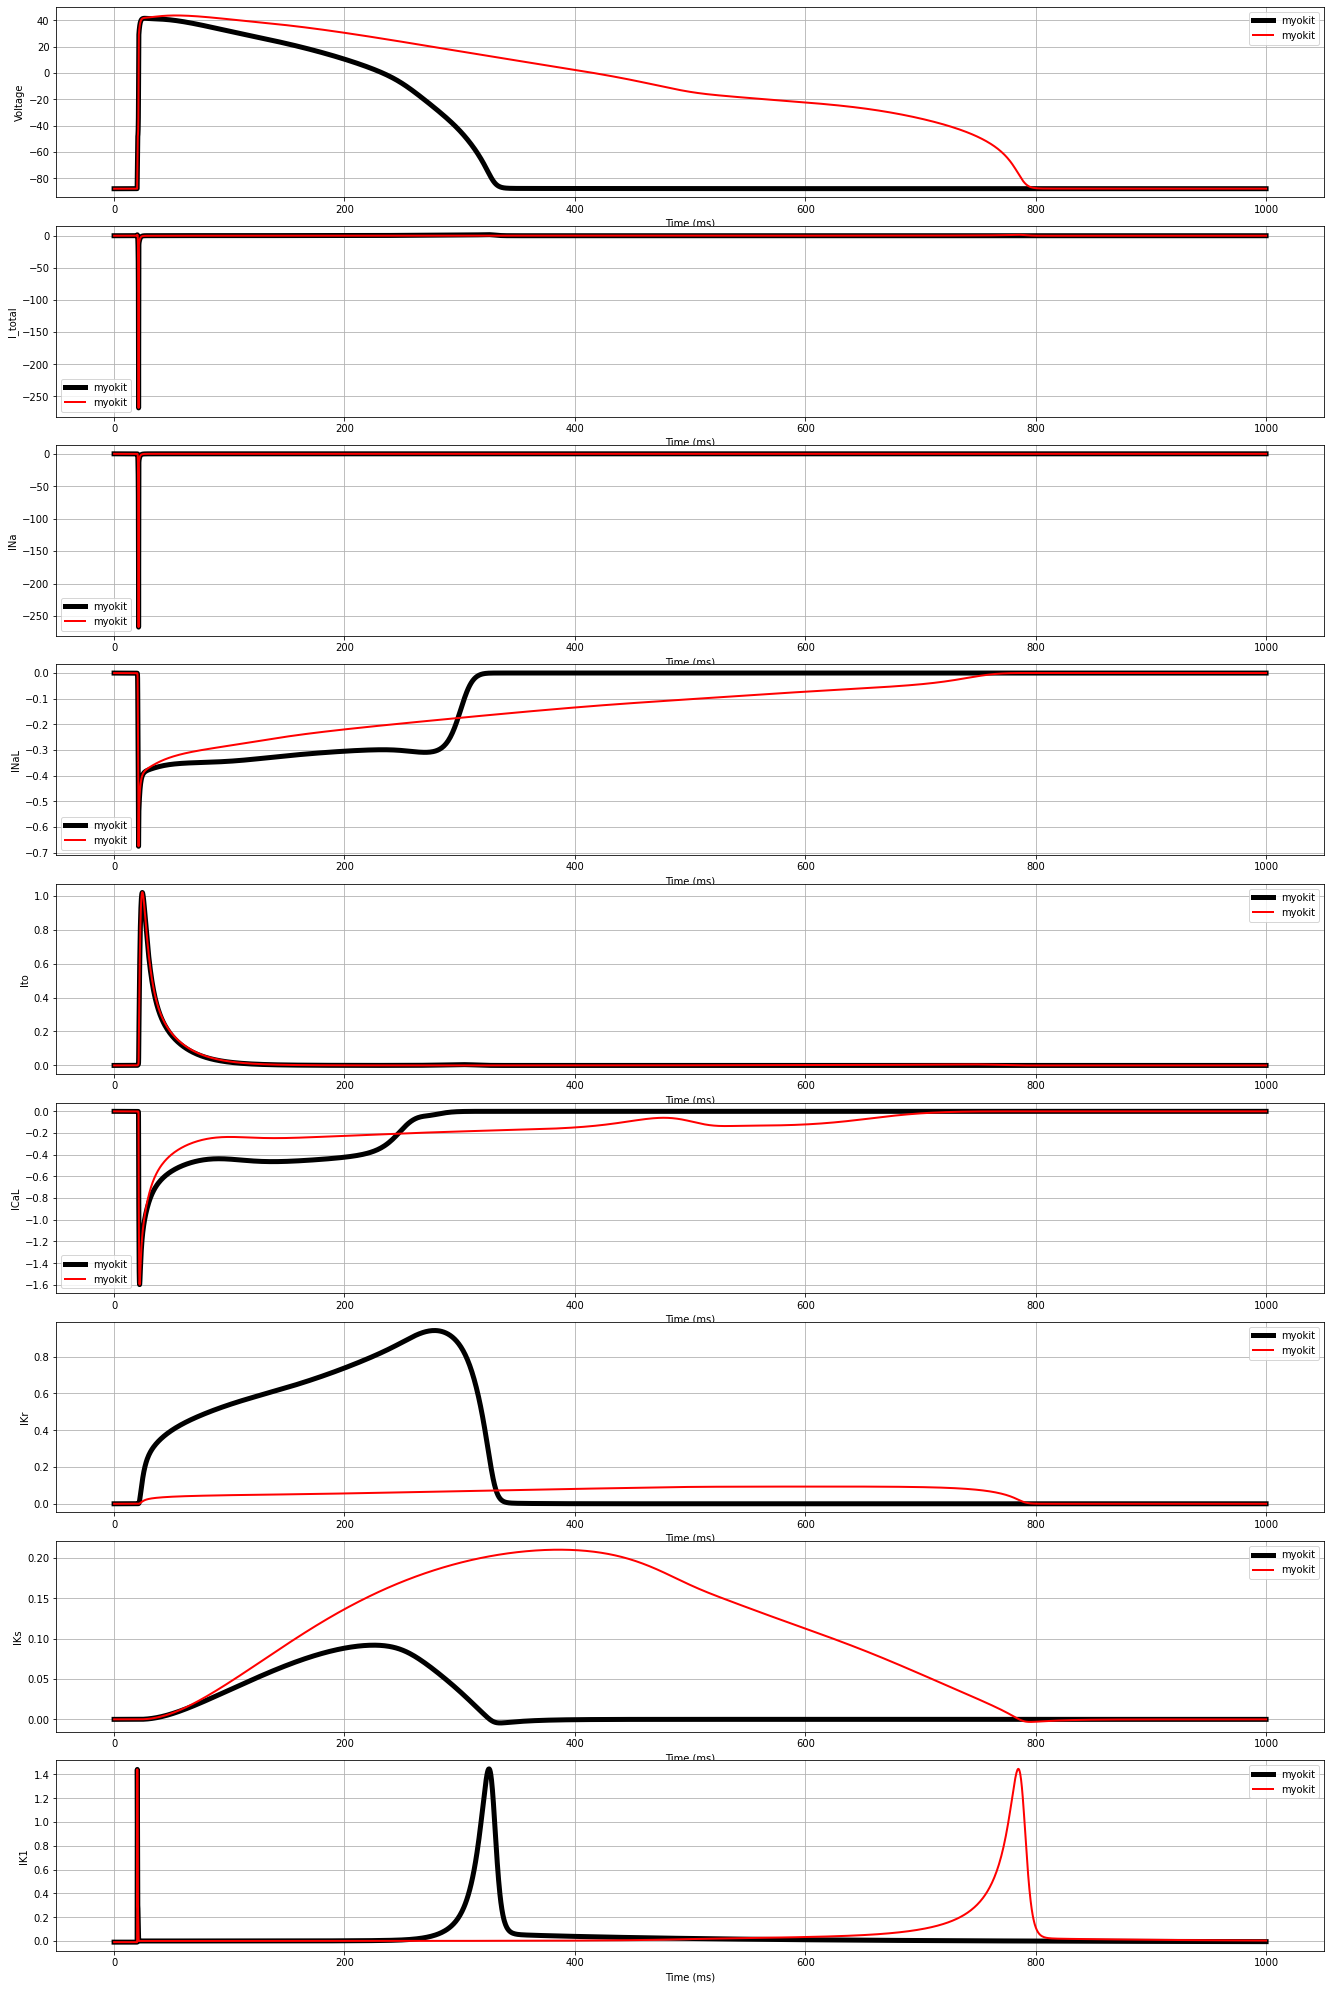

In [15]:
'''
Plot
'''
fig, ax = plt.subplots(len(sol1),1, figsize=(20,30))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol1.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times1, sol1[name], label='myokit', color='k', linewidth=5)    
    ax[i].plot( times2, sol2[name], label='myokit', color='r', linewidth=2)    
    ax[i].legend()
    ax[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join(result_dir, "channel_block_test_AP.jpg"), dpi=100)